In [24]:
%reload_ext autoreload
%autoreload 2

import os
import sys
from tqdm import tqdm

import numpy as np
import healpy as hp
from astropy.io import fits
from astropy.coordinates import SkyCoord
from scipy.signal import convolve2d

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colormaps as cms
mpl.rc_file('../matplotlibrc')

In [48]:
sys.path.append("..")
import axionmirror.units_constants as uc
from axionmirror.egrs import egrs_list_keuhr, egrs_list_cora, egrs_list_all

## 0. set grid

In [3]:
pixel_size = np.deg2rad(0.25) # [rad]
b_edges = np.linspace(-np.pi/2, np.pi/2, 1+int(np.round(  np.pi/pixel_size)))
l_edges = np.linspace(-np.pi,   np.pi,   1+int(np.round(2*np.pi/pixel_size)))
b_s = (b_edges[:-1] + b_edges[1:]) / 2
l_s = (l_edges[:-1] + l_edges[1:]) / 2
l_grid, b_grid = np.meshgrid(l_s, b_s)

## 1. haslam residual

In [4]:
nu_haslam = 408 # [MHz]
beta = -2.5
T_min = 1e-3 # [K]

haslam_ds_map_hp = hp.read_map('../data/gsr/haslam408_ds_Remazeilles2014.fits')
haslam_dsds_map_hp = hp.read_map('../data/gsr/haslam408_dsds_Remazeilles2014.fits')
haslam_src_map_hp = np.maximum(haslam_ds_map_hp-haslam_dsds_map_hp, T_min)

haslam_src_map = hp.pixelfunc.get_interp_val(
    haslam_src_map_hp, np.rad2deg(l_grid), np.rad2deg(b_grid), lonlat=True
)

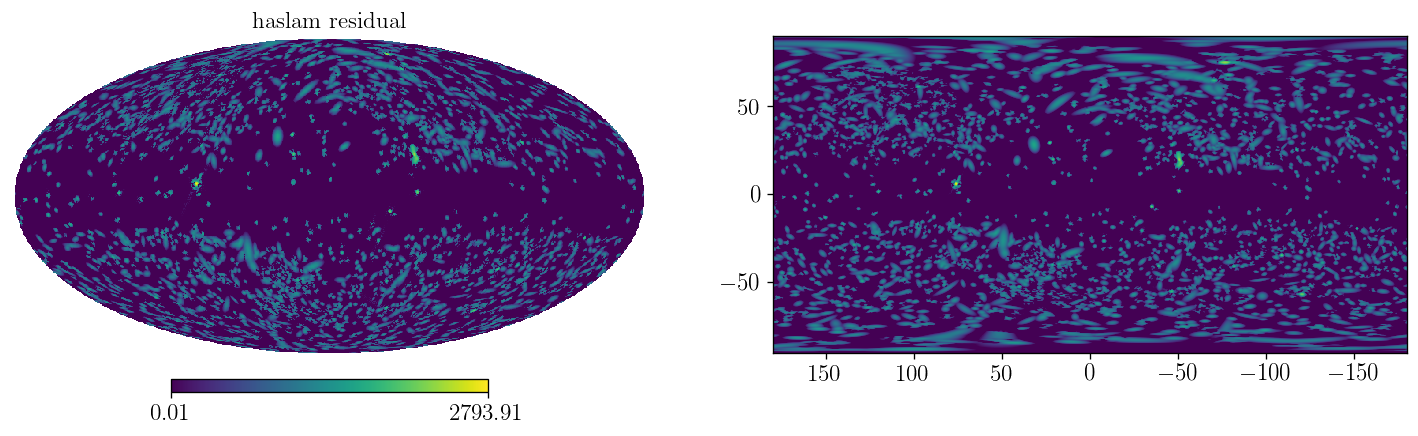

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

plt.axes(axs[0])
hp.mollview(haslam_src_map_hp, hold=True, norm='log', min=1e-2, title='haslam residual')

axs[1].imshow(np.flip(np.log10(haslam_src_map)), vmin=-2, extent=(180, -180, -90, 90))

In [6]:
np.mean(haslam_src_map_hp)

0.388962

## 2. Keuhr catalog

In [4]:
egrs_list = egrs_list_keuhr()
print(len(egrs_list))

519


### 2.1 Spectra

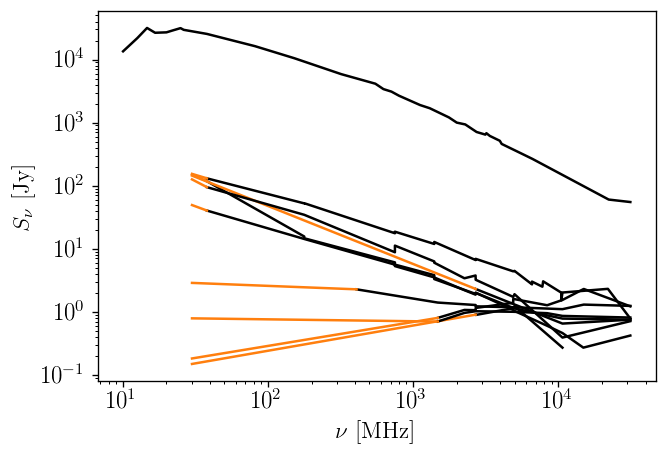

In [4]:
fig, ax = plt.subplots()

for egrs in egrs_list[-10:]:
    egrs.plot_spec(ax)

ax.set(xscale='log', yscale='log')
ax.set(xlabel=r'$\nu$ [MHz]', ylabel=r'$S_\nu$ [Jy]');

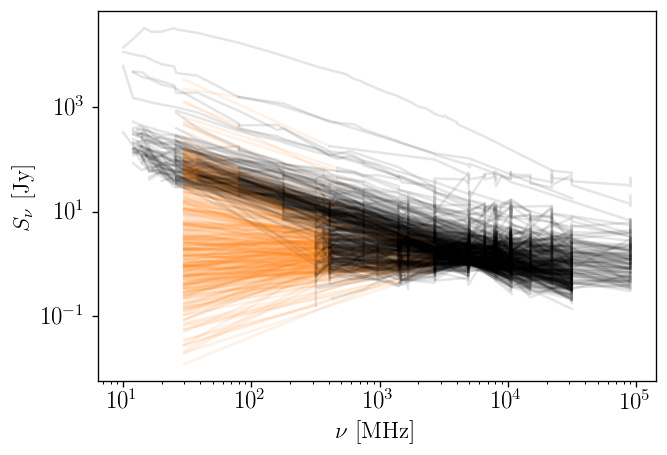

In [5]:
fig, ax = plt.subplots()

for egrs in egrs_list:
    egrs.plot_spec(ax, alpha=0.1)

ax.set(xscale='log', yscale='log')
ax.set(xlabel=r'$\nu$ [MHz]', ylabel=r'$S_\nu$ [Jy]');

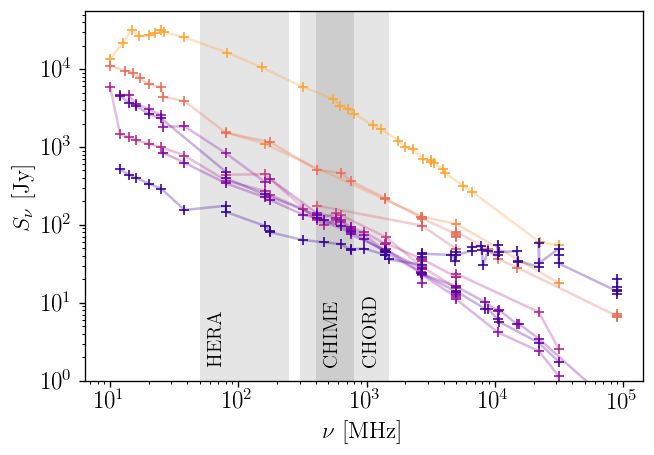

In [26]:
ind_best = np.argsort([egrs.Snu_no_extrap(1000) for egrs in egrs_list])[::-1]

fig, ax = plt.subplots()

for i_ind, ind in enumerate(ind_best[:10]):
    color = cms['plasma'](0.8 - 0.08 * i_ind)
    egrs_list[ind].plot_spec(ax, extrap=False, interp_color=color, alpha=0.3, markeralpha=1)

ax.axvspan(50, 250, color='k', alpha=0.1, ec=None)
ax.axvspan(400, 800, color='k', alpha=0.1, ec=None)
ax.axvspan(300, 1500, color='k', alpha=0.1, ec=None)

ax.text(50*1.15, 1.5, 'HERA', rotation=90, va='bottom', ha='left')
ax.text(400*1.15, 1.5, 'CHIME', rotation=90, va='bottom', ha='left')
ax.text(800*1.15, 1.5, 'CHORD', rotation=90, va='bottom', ha='left')

ax.set(xscale='log', yscale='log')
ax.set(ylim=(1e0, None))
ax.set(xlabel=r'$\nu$ [MHz]', ylabel=r'$S_\nu$ [Jy]')
fig.savefig('egrs_top_spec.pdf');

In [18]:
for i_ind, ind in enumerate(ind_best[:10]):
    print(egrs_list[ind].name)

Cyg A
1322-42
1228+12
0320-37
0518-45
1717-00
1648+05
0433+29
0915-11
1226+02


In [49]:
# with inclusion of cora sources
el_all = egrs_list_all()
ind_best = np.argsort([egrs.Snu_no_extrap(1000) for egrs in el_all])[::-1]
for i_ind, ind in enumerate(ind_best[:10]):
    print(el_all[ind].name)

Cyg A
1322-42
1228+12
0320-37
0518-45
1717-00
1648+05
0433+29
0915-11
1226+02


### 2.2 Locations of all the sources

In [30]:
egrs_b_s = np.rad2deg([egrs.b for egrs in egrs_list])
egrs_l_s = np.rad2deg([egrs.l for egrs in egrs_list])
inds_plot = np.abs(egrs_b_s) < 25

[None]

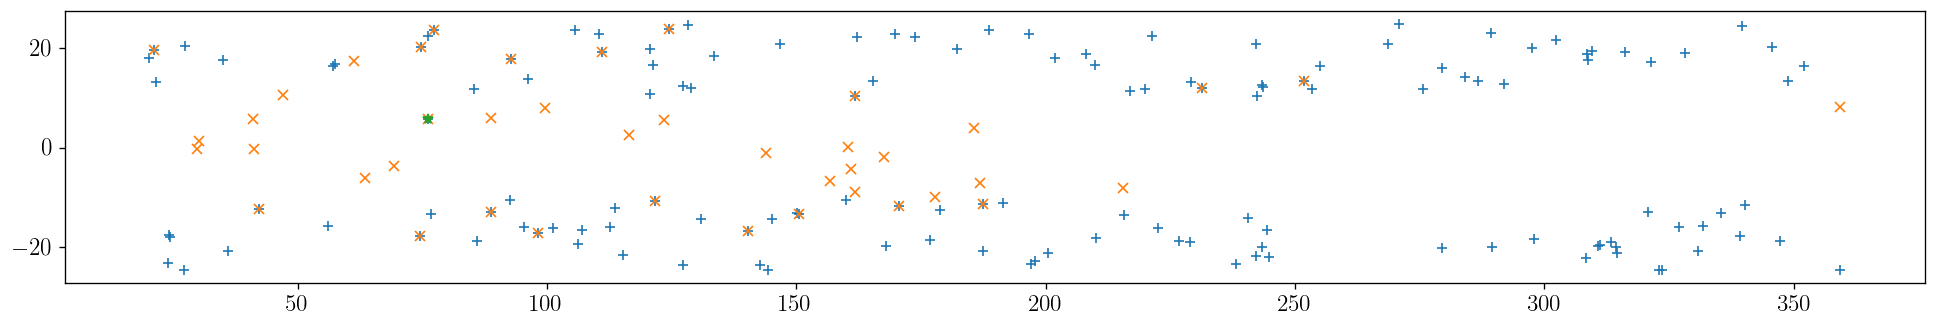

In [46]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(egrs_l_s[inds_plot], egrs_b_s[inds_plot], '+')
ax.plot(cora_l_s[cora_inds_plot], cora_b_s[cora_inds_plot], 'x')
ax.plot(egrs_l_s[-1], egrs_b_s[-1], '*')
ax.set(aspect=1)

### 2.3 Making a map

In [11]:
src_map = np.zeros_like(b_grid)
prev_name = ''

for egrs in egrs_list:
        
    pixel_area = pixel_size ** 2 * np.cos(egrs.b) # [rad^2]
    I = egrs.Snu(nu_haslam)/pixel_area # [Jy sr^-1]
    # I = 2 * nu^2 kb T / c0^2
    # [MHz^2 g sr^-1] = [MHz^2] [cm^2 MHz^2 g] [cm^-2 MHz^-2]
    T = I * uc.Jy / (2 * nu_haslam**2 * uc.kb / uc.c0**2)

    i_b = np.searchsorted(b_edges[:-1], egrs.b) - 1
    i_l = np.searchsorted(l_edges[:-1], egrs.l_0center) - 1
    if T > 1e5:
        print('?')
    src_map[i_b, i_l] += T

In [12]:
n_sigma = 5
kernel_size = np.deg2rad(0.5) # [rad]
n_pix = int(np.round(2*n_sigma*kernel_size/pixel_size)) - 1
kernel = np.zeros((n_pix, n_pix))
i_c = (n_pix-1) / 2
for i in range(n_pix):
    for j in range(n_pix):
        kernel[i, j] = np.exp(- ((i-i_c)**2+(j-i_c)**2) / (2 * (kernel_size/pixel_size)**2))
kernel /= np.sum(kernel)
src_map_smoothed = convolve2d(src_map, kernel, mode='same')

In [13]:
np.mean(src_map), np.mean(src_map_smoothed)

(0.10966211754139289, 0.10936117479121149)

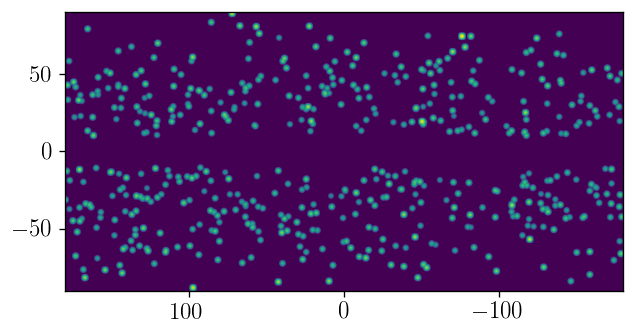

In [14]:
plt.imshow(np.flip(np.log10(np.clip(src_map_smoothed, 1e-5, None))), extent=(180, -180, -90, 90))